# Music Genre Classification using multiple classifiers
Team Members: Lisa Korntheuer, Jan Birkert, Adrian Desiderato, Jan Wangerin, Spyridon Spyropoulos

## Imports

In [22]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
import seaborn as sns
from sklearn.decomposition import PCA

# 0. Data understanding
Data describe (Features, Target etc.)
- filename and length irrelevant for ML
- 57 features -> PCA?
- only numerical data except for class labels ("label")

In [7]:
df = pd.read_csv('./data/features_30_sec.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 1000 non-null   object 
 1   length                   1000 non-null   int64  
 2   chroma_stft_mean         1000 non-null   float64
 3   chroma_stft_var          1000 non-null   float64
 4   rms_mean                 1000 non-null   float64
 5   rms_var                  1000 non-null   float64
 6   spectral_centroid_mean   1000 non-null   float64
 7   spectral_centroid_var    1000 non-null   float64
 8   spectral_bandwidth_mean  1000 non-null   float64
 9   spectral_bandwidth_var   1000 non-null   float64
 10  rolloff_mean             1000 non-null   float64
 11  rolloff_var              1000 non-null   float64
 12  zero_crossing_rate_mean  1000 non-null   float64
 13  zero_crossing_rate_var   1000 non-null   float64
 14  harmony_mean             

In [42]:
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


Correlations between features:

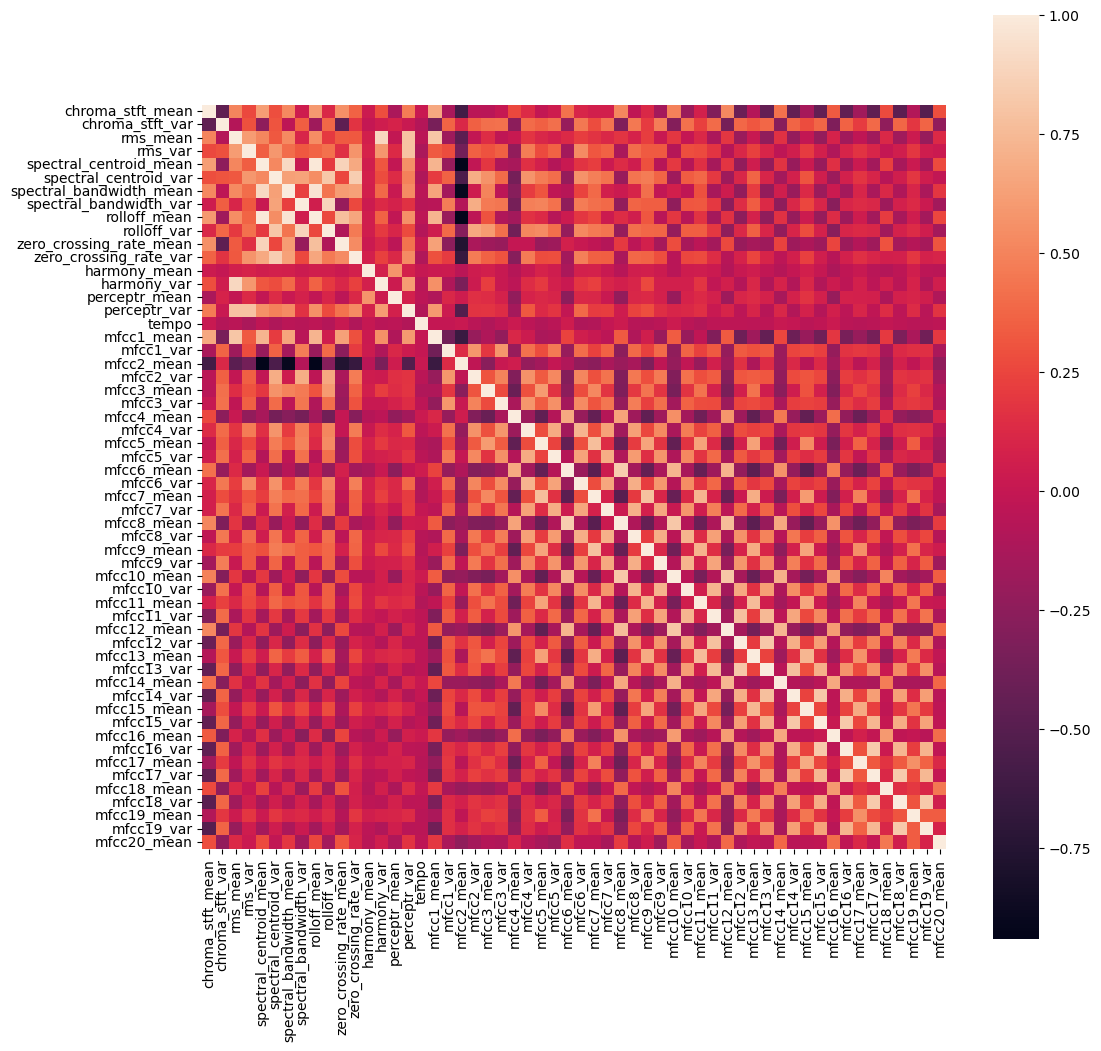

In [19]:
cor = df.iloc[:, 2:-2].corr()
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(cor, square = True, xticklabels=True, yticklabels=True) 
plt.show()

Since there are quite a few feature combinations with high correlations, PCA may be worth a try. (See Data Prep)

## 1. Data preparation
Jan W.

Data splitting

y = LabelEncoder() 

MinMax()
Das andere() 


In [26]:
LabelEnc = LabelEncoder()
y = df['label']
y = pd.DataFrame(LabelEnc.fit_transform(y))
df['label_enc'] = y

In [28]:
scaler_mms = MinMaxScaler()
scaler_ss = StandardScaler()
X = df.loc[:, 'chroma_stft_mean' : 'mfcc20_var']
X_scaled_array_mms = scaler_mms.fit_transform(X)
X_scaled_array_ss = scaler_ss.fit_transform(X)
X_scaled_mms = pd.DataFrame(X_scaled_array_mms, columns=X.columns)
X_scaled_ss = pd.DataFrame(X_scaled_array_ss, columns=X.columns)
print(X)
print(X_scaled_mms)
print(X_scaled_ss)

     chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0            0.350088         0.088757  0.130228  0.002827   
1            0.340914         0.094980  0.095948  0.002373   
2            0.363637         0.085275  0.175570  0.002746   
3            0.404785         0.093999  0.141093  0.006346   
4            0.308526         0.087841  0.091529  0.002303   
..                ...              ...       ...       ...   
995          0.352063         0.080487  0.079486  0.000345   
996          0.398687         0.075086  0.076458  0.000588   
997          0.432142         0.075268  0.081651  0.000322   
998          0.362485         0.091506  0.083860  0.001211   
999          0.358401         0.085884  0.054454  0.000336   

     spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0               1784.165850          129774.064525              2002.449060   
1               1530.176679          375850.073649              2039.036516   
2               15

PCA: (copied from Material Notebook 04, probably has to be adjusted later on)

In [42]:
pca = PCA() # typically you add here as a parameter the nbr. of cmponents: i.e.: n_components=2
            # we leave it blank to get all!
pcs = pca.fit_transform(X_scaled_ss) # principle components

Eigenvalues:

In [50]:
print(pca.explained_variance_)
print(pca.explained_variance_ratio_)

[1.36649163e+01 9.65933079e+00 6.13364937e+00 4.33745591e+00
 2.61211618e+00 1.95989991e+00 1.70854392e+00 1.48113059e+00
 1.37118739e+00 1.07178668e+00 1.01254095e+00 9.24210833e-01
 7.50459385e-01 7.30963394e-01 6.44143574e-01 5.53745978e-01
 5.00178062e-01 4.64827693e-01 4.22397102e-01 4.07898891e-01
 3.85542239e-01 3.78955337e-01 3.62153149e-01 3.35032633e-01
 3.20003021e-01 3.01141898e-01 2.95709370e-01 2.85864666e-01
 2.75069740e-01 2.62752066e-01 2.48764454e-01 2.36549303e-01
 2.26002431e-01 2.16665436e-01 2.12592600e-01 1.98351665e-01
 1.95437861e-01 1.80251572e-01 1.74450532e-01 1.68263501e-01
 1.57569674e-01 1.46933998e-01 1.33990883e-01 1.25358591e-01
 1.20439773e-01 1.16404630e-01 1.07480664e-01 9.99399712e-02
 8.87346221e-02 8.60404693e-02 7.52295016e-02 5.27684212e-02
 3.64051449e-02 2.31935376e-02 8.00344303e-03 5.44102739e-03
 2.18634001e-03]
[2.39495638e-01 1.69292482e-01 1.07500276e-01 7.60196220e-02
 4.57807730e-02 3.43498248e-02 2.99444803e-02 2.59587625e-02
 2.4031

Principal Components (Dot Product of Data and Eigenvectors):

In [48]:
print(pcs[:5])
print()
print(len(pcs))

[[-2.78356454e+00 -1.02936476e+00 -5.22219128e-01 -1.15967714e-01
  -7.13896125e-01  9.91845317e-01  3.53364789e-01 -4.00634623e-01
  -1.72260523e-01 -3.49387128e-01 -1.02344445e-01 -3.72763321e-01
  -6.60584136e-01 -1.09129048e-01 -5.63449294e-01 -3.82415378e-01
   3.88258453e-01 -6.17636011e-01 -3.18070254e-01  6.68235904e-02
  -5.16876750e-01  8.48467253e-02 -4.93548579e-01  4.08720491e-01
   3.18512360e-01 -1.78949361e-01  2.99620977e-01  2.15001340e-01
  -4.62915730e-01 -1.19703865e-01  9.28363069e-02  1.47350306e-01
   1.19259697e-01  4.69338355e-01 -4.40068791e-01  1.63277611e-01
  -7.52907361e-02  1.88597493e-01 -1.45613582e-01  4.48205032e-01
  -2.12494059e-01 -2.34070807e-01  8.50717536e-02 -1.53881848e-01
  -1.32787046e-01 -4.69960101e-02  9.81616691e-02  2.91886573e-01
  -2.71947563e-01  6.86067684e-03 -2.34984829e-01  5.70604365e-02
   4.16443053e-02  7.18943674e-03  4.28527618e-02  2.13067568e-02
   5.14542045e-03]
 [ 1.72752117e+00 -1.16572684e+00  1.34813922e+00 -2.4608

Scree Plot with Kaiser Criteria

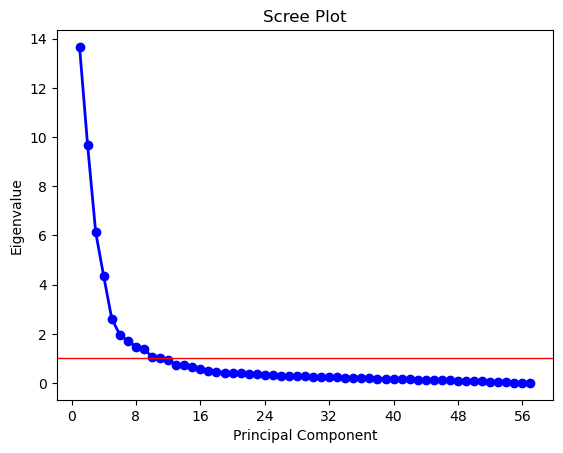

In [53]:
import matplotlib.ticker as ticker
fig = plt.figure()
ax = plt.axes()

pc_values = np.arange(pca.n_components_) + 1
ax.plot(pc_values, pca.explained_variance_, 'o-', linewidth=2, color='blue')
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.axhline(y=1, linewidth=1, color='r')
plt.show()

Potentially, a lot of dimensions could be removed according to the Kaiser criteria. The following enumeration shows how much "information" is contained in how many of the principal components:

In [60]:
for i in [10, 15, 30, 45]:
    print(np.sum(pca.explained_variance_ratio_[:i]))

0.7711581932475338
0.8423556637148908
0.9396490070759943
0.9876995448225625


To fight the curse of dimensionality, some dimensions could be removed, for example the last 12 to even 27 dimensions, since about 94% of "information" is contained in the first 30 PCs.

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
X_train_mms, X_test_mms, y_train_mms, y_test_mms = train_test_split(X_scaled_mms, y, test_size=0.2, random_state=0, stratify=y)
X_train_ss, X_test_ss, y_train_ss, y_test_ss = train_test_split(X_scaled_ss, y, test_size=0.2, random_state=0, stratify=y)

## 2. Model training 

Each Modell is trained and the quality of the classifier(accuracy) is displayed. 

### 2.1 Random Forests
Spyridon

In [46]:
from sklearn.ensemble import RandomForestClassifier
import sklearn.tree as tree

rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train.values.ravel())
rf_mms = RandomForestClassifier(random_state=0)
rf_mms.fit(X_train_mms, y_train_mms.values.ravel())
rf_ss = RandomForestClassifier(random_state=0)
rf_ss.fit(X_train_ss, y_train_ss.values.ravel())
y_pred = rf.predict(X_test)
y_pred_mms = rf_mms.predict(X_test_mms)
y_pred_ss = rf_ss.predict(X_test_ss)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Accuracy: {accuracy_score(y_test_mms, y_pred_mms)}")
print(f"Accuracy: {accuracy_score(y_test_ss, y_pred_ss)}")

Accuracy: 0.75
Accuracy: 0.74
Accuracy: 0.745


### 2.2 Decision trees

Jan W.

### 2.3 Knn
Lisa 

### 2.4 Logistic Regression
Jan B.

### 2.5 Neural Networks

### 2.6 Bayes
Adrian 

## 2.7 K-Means (OPTIONAL)

## 3. Comparing Models 

AUC + ROC 
Accuracy summary

## 4. OPTIONAL: Song import and classify

## 5. References 